In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sweetviz as sv
import category_encoders as ce
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
heart_dis_pred = pd.read_csv("heart_cleaned_encoded_smote.csv")

In [5]:
predictors = heart_dis_pred.drop("HeartDisease_No",axis=1)
target = heart_dis_pred["HeartDisease_No"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

# Naive Bayes with Scaling + SMOTE

In [6]:
%%time
nb = GaussianNB()
nb.fit(X_train,Y_train)

Wall time: 1.52 s


GaussianNB()

In [7]:
Y_pred_nb = nb.predict(X_test)

In [8]:
pkl.dump(nb, open('model_nb.pkl', 'wb'))

In [9]:
yTest = Y_test.to_frame(name = "HeartDisease_No")
tn, fp, fn, tp = confusion_matrix(yTest, Y_pred_nb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  42684 
False positives:  4046 
False negatives:  3160 
True Positives:  43686


In [10]:
print(classification_report(yTest, Y_pred_nb))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     46730
           1       0.92      0.93      0.92     46846

    accuracy                           0.92     93576
   macro avg       0.92      0.92      0.92     93576
weighted avg       0.92      0.92      0.92     93576



In [11]:
test = pd.concat([X_test, Y_test], axis=1)

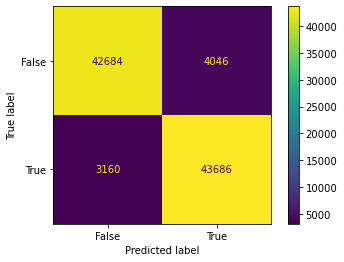

In [12]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(yTest['HeartDisease_No'], Y_pred_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [13]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(test, label='HeartDisease_No'), nb)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\checks.py:21: DeprecationWarning:

Ability to import tabular checks from the `deepchecks.checks` is deprecated, please import from `deepchecks.tabular.checks` instead

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


# Naive Bayes with Scaling + SMOTE + PCA

In [14]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_pca.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_pca.csv")

In [15]:
%%time
features = ['principal component 1','principal component 2','principal component 3','principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13','principal component 14','principal component 15','principal component 16','principal component 17','principal component 18','principal component 19','principal component 20']
nb = GaussianNB()
nb.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])

Wall time: 941 ms


GaussianNB()

In [16]:
Y_pred_nb = nb.predict(heart_dis_test_pred[features])

In [17]:
pkl.dump(nb, open('model_nb_pca.pkl', 'wb'))

In [18]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  3151 
False positives:  2324 
False negatives:  10237 
True Positives:  48247


In [19]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb))

              precision    recall  f1-score   support

           0       0.24      0.58      0.33      5475
           1       0.95      0.82      0.88     58484

    accuracy                           0.80     63959
   macro avg       0.59      0.70      0.61     63959
weighted avg       0.89      0.80      0.84     63959



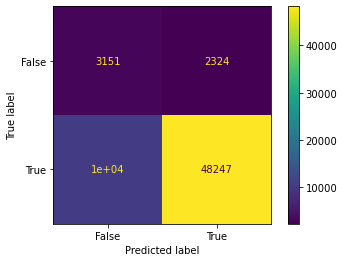

In [20]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [21]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]

In [22]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), nb)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


# Naive Bayes with Scaling + SMOTE + ICA

In [23]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_ica.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_ica.csv")

In [24]:
%%time
features = ['independent component 1','independent component 2','independent component 3','independent component 4','independent component 5','independent component 6','independent component 7','independent component 8','independent component 9','independent component 10','independent component 11','independent component 12','independent component 13','independent component 14','independent component 15','independent component 16','independent component 17','independent component 18','independent component 19','independent component 20']
nb = GaussianNB()
nb.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])

Wall time: 445 ms


GaussianNB()

In [25]:
Y_pred_nb = nb.predict(heart_dis_test_pred[features])

In [26]:
pkl.dump(nb, open('model_nb_ica.pkl', 'wb'))

In [27]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  3384 
False positives:  2091 
False negatives:  11301 
True Positives:  47183


In [28]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb))

              precision    recall  f1-score   support

           0       0.23      0.62      0.34      5475
           1       0.96      0.81      0.88     58484

    accuracy                           0.79     63959
   macro avg       0.59      0.71      0.61     63959
weighted avg       0.90      0.79      0.83     63959



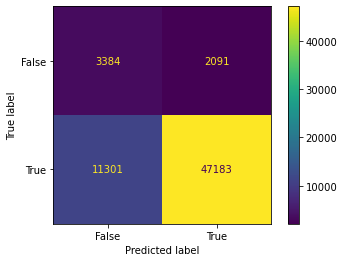

In [29]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [30]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]

In [31]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), nb)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.


# Naive Bayes with Scaling + SMOTE + LDA

In [32]:
heart_dis_train_pred = pd.read_csv("heart_cleaned_encoded_trained_lda.csv")
heart_dis_test_pred = pd.read_csv("heart_cleaned_encoded_tested_lda.csv")

In [33]:
%%time
features = ['lda 1']
nb = GaussianNB()
nb.fit(heart_dis_train_pred[features],heart_dis_train_pred["HeartDisease_No"])

Wall time: 68.7 ms


GaussianNB()

In [34]:
Y_pred_nb = nb.predict(heart_dis_test_pred[features])

In [35]:
pkl.dump(nb, open('model_nb_lda.pkl', 'wb'))

In [36]:
tn, fp, fn, tp = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)

True negatives:  4248 
False positives:  1227 
False negatives:  15152 
True Positives:  43332


In [37]:
print(classification_report(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb))

              precision    recall  f1-score   support

           0       0.22      0.78      0.34      5475
           1       0.97      0.74      0.84     58484

    accuracy                           0.74     63959
   macro avg       0.60      0.76      0.59     63959
weighted avg       0.91      0.74      0.80     63959



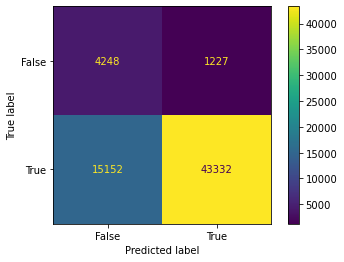

In [38]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(heart_dis_test_pred["HeartDisease_No"], Y_pred_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [39]:
heart_dis_test_pred = heart_dis_test_pred.loc[:, ~heart_dis_test_pred.columns.str.contains('^Unnamed')]

In [40]:
from deepchecks.checks import RocReport
from deepchecks import Dataset

RocReport().run(Dataset(heart_dis_test_pred, label='HeartDisease_No'), nb)

C:\Users\chemb\anaconda3\lib\site-packages\deepchecks\__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead

deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
